# The Scalar Wave Equation: Creating an Einstein Toolkit thorn

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

### NRPy+ Source Code for this module: 
* [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py) [\[**tutorial**\]](Tutorial-ScalarWave.ipynb) 
* [ScalarWave/InitialData_PlaneWave.py](../edit/ScalarWave/InitialData_PlaneWave.py)[\[**tutorial**\]](Tutorial-ScalarWave.ipynb)

## Introduction:
This tutorial module focuses on how to construct an Einstein Toolkit (ETK) thorn (module) that will set up the expressions for the right-hand sides of $\partial_t u$ and $\partial_t v$ for the scalar wave equation, as defined in the [Tutorial-ScalarWave.ipynb](Tutorial-ScalarWave.ipynb) NRPy+ tutorial module. In that module, we used NRPy+ to contruct the SymPy expressions for these scalar wave "time-evolution equations". This thorn is largely based on and should function similarly to the $\text{WaveToyC}$ thorn included in the Einstein Toolkit (ETK) $\text{CactusWave}$ arrangement.

When interfaced properly with the ETK, this module will propagate the initial data for $u$ and $v$ defined in [IDScalarWaveNRPy](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb) forward in time by integrating the equations for $\partial_t u$ and $\partial_t v$ subject to spatial boundary conditions. The time evolution itself is handled by the $\text{MoL}$ (Method of Lines) thorn in the $\text{CactusNumerical}$ arrangement, and the boundary conditions by the $\text{Boundary}$ thorn in the $\text{CactusBase}$ arrangement. 

Similar to the [IDScalarWaveNRPy](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb) module, we will construct the WaveToyNRPy module in two steps.

1. Call on NRPy+ to convert the SymPy expressions for the evolution equations into one C-code kernel.
1. Write the C code and linkages to the Einstein Toolkit infrastructure (i.e., the .ccl files) to complete this Einstein Toolkit module.

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This module is organized as follows

1. [Step 1](#initializenrpy): Call on NRPy+ to convert the SymPy expressions for the Scalar Wave evolution equations' RHSs into a C-code kernel
1. [Step 2](#etk): Interfacing with the Einstein Toolkit
    1. [Step 2.a](#etkc): Constructing the Einstein Toolkit C-code calling functions that include the C code kernels
    1. [Step 2.b](#cclfiles): CCL files - Define how this module interacts and interfaces with the larger Einstein Toolkit infrastructure
    1. [Step 2.c](#etk_list): Add the C file to Einstein Toolkit compilation list
1. [Step 3](#code_validation): Code Validation, Convergence Tests
1. [Step 4](#latex_pdf_output): Output this module to $\LaTeX$-formatted PDF file

<a id='initializenrpy'></a>

# Step 1: Call on NRPy+ to convert the SymPy expressions for the Scalar Wave evolution equations' RHSs into a C-code kernel \[Back to [top](#toc)\]
$$\label{initializenrpy}$$

After importing the core modules, we will set $\text{GridFuncMemAccess}$ to $\text{ETK}$. SymPy expressions for the scalar wave evolution equations' RHSs are written inside [ScalarWave/ScalarWave_RHSs.py](../edit/ScalarWave/ScalarWave_RHSs.py), and we simply import them for use here.


In [1]:
# Step 1a: Import needed NRPy+ core modules:
import NRPy_param_funcs as par
import indexedexp as ixp
import grid as gri
import finite_difference as fin
from outputC import *
import loop

# Step 1b: This is an Einstein Toolkit (ETK) thorn. Here we
#          tell NRPy+ that gridfunction memory access will 
#          therefore be in the "ETK" style.
par.set_parval_from_str("grid::GridFuncMemAccess","ETK")

# Step 1c: Set the finite differencing order. 
#         IMPORTANT: If you set FD_CENTDERIVS_ORDER to 8, be sure to use
#                    the parameter files and scripts in the directory:
#                    WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTest
#                    If you set FD_CENTDERIVS_ORDER to 4, be sure to use
#                    the parameter files and scripts in the directory:
#                    WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests
par.set_parval_from_str("finite_difference::FD_CENTDERIVS_ORDER",4) # SET TO EIGHTH ORDER

# Step 1d: Call the ScalarWave_RHSs() function from within the
#          ScalarWave/ScalarWave_RHSs.py module. 
#          This sets swrhs.uu_rhs and swrhs.vv_rhs.
import ScalarWave.ScalarWave_RHSs as swrhs
swrhs.ScalarWave_RHSs()

Now, we need to output these expressions to C code kernel, which will be housed within a file named "ScalarWave_RHSs.h". This "header" file will be #include'd in the main C file below. Also, so that we can check that the number of ghost zones in the ETK numerical grid is set properly, we will also output the NRPy+ `finite_difference::FD_CENTDERIVS_ORDER parameter` to a `#`define statement within "NRPy_params.h".


In [2]:
# Step 2: Register uu_rhs and vv_rhs gridfunctions so 
#         they can be written to by NRPy.
uu_rhs,vv_rhs = gri.register_gridfunctions("AUX",["uu_rhs","vv_rhs"])

# Step 3: Create the C code output kernel.
scalar_RHSs_to_print = [\
                        lhrh(lhs=gri.gfaccess("out_gfs","uu_rhs"),rhs=swrhs.uu_rhs),\
                        lhrh(lhs=gri.gfaccess("out_gfs","vv_rhs"),rhs=swrhs.vv_rhs),]
scalar_RHSs_CcodeKernel = fin.FD_outputC("returnstring",scalar_RHSs_to_print)

scalar_RHSs_looped = loop.loop(["i2","i1","i0"],["cctk_nghostzones[2]","cctk_nghostzones[1]","cctk_nghostzones[0]"],\
                               ["cctk_lsh[2]-cctk_nghostzones[2]","cctk_lsh[1]-cctk_nghostzones[1]",\
                                "cctk_lsh[0]-cctk_nghostzones[0]"],\
                               ["1","1","1"],["#pragma omp parallel for","",""],"",scalar_RHSs_CcodeKernel)

# Step 4: Create directories for the thorn if they don't exist.
!mkdir WaveToyNRPy     2>/dev/null # 2>/dev/null: Don't throw an error if the directory already exists.
!mkdir WaveToyNRPy/src 2>/dev/null # 2>/dev/null: Don't throw an error if the directory already exists.

# Step 5: Write the C code kernel to file.
with open("WaveToyNRPy/src/ScalarWave_RHSs.h", "w") as file:
    file.write(str(scalar_RHSs_looped))

with open("WaveToyNRPy/src/NRPy_params.h", "w") as file:
    file.write("#define FD_CENTDERIVS_ORDER "+str(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER"))+"\n")

<a id='etk'></a>

# Step 2: Interfacing with the Einstein Toolkit \[Back to [top](#toc)\]
$$\label{etk}$$


<a id='etkc'></a>

## Step 2.a: Constructing the Einstein Toolkit C-code calling functions that include the C code kernels \[Back to [top](#toc)\]
$$\label{etkc}$$

Now that we have generated the C code kernel *ScalarWave_RHSs.h* and the parameters file *NRPy_params.h*, we will need to write C code to make use of these files. To do this, we can simply follow the example within the [IDScalarWaveNRPy tutorial module](Tutorial-ETK_thorn-IDScalarWaveNRPy.ipynb). Functions defined by these files will be called by the Einstein Toolkit scheduler (specified in schedule.ccl below).

In [3]:
%%writefile WaveToyNRPy/src/WaveToyNRPy.c
#include <math.h>
#include <stdio.h>

#include "cctk.h"
#include "cctk_Arguments.h"
#include "cctk_Parameters.h"
#include "Symmetry.h"

#include "NRPy_params.h"

void WaveToyNRPy_check_params(CCTK_ARGUMENTS) {
    DECLARE_CCTK_ARGUMENTS;

    if( (cctk_nghostzones[0] != FD_CENTDERIVS_ORDER/2) || 
        (cctk_nghostzones[1] != FD_CENTDERIVS_ORDER/2) || 
        (cctk_nghostzones[2] != FD_CENTDERIVS_ORDER/2) ) {
            char error_string[200];
            sprintf(error_string,"WaveToyNRPy_check_params: expected ghost_size to be set to %d , but found ghostxyz = %d %d %d\n",
                    FD_CENTDERIVS_ORDER/2,cctk_nghostzones[0],cctk_nghostzones[1],cctk_nghostzones[2]);
            CCTK_WARN (0, error_string);
    }
}

void WaveToyNRPy_set_rhs(CCTK_ARGUMENTS) {
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  
  const CCTK_REAL invdx0 = 1.0 / (CCTK_DELTA_SPACE(0));
  const CCTK_REAL invdx1 = 1.0 / (CCTK_DELTA_SPACE(1));
  const CCTK_REAL invdx2 = 1.0 / (CCTK_DELTA_SPACE(2));
  
#include "ScalarWave_RHSs.h" 
}

/* Boundary Condition code adapted from WaveToyC thorn in ETK, implementing built-in
 * ETK BC functionality
 */
void WaveToyNRPy_SelectBCs(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;

  const char *bctype;


  bctype = NULL;
  if (CCTK_EQUALS(bound,"flat") || CCTK_EQUALS(bound,"static") ||
      CCTK_EQUALS(bound,"radiation") || CCTK_EQUALS(bound,"robin") ||
      CCTK_EQUALS(bound,"none"))
  {
    bctype = bound;
  }
  else if (CCTK_EQUALS(bound,"zero"))
  {
    bctype = "scalar";
  }

  /* Uses all default arguments, so invalid table handle -1 can be passed */
  if (bctype && Boundary_SelectVarForBC (cctkGH, CCTK_ALL_FACES, 1, -1,
                                         "WaveToyNRPy::uuGF", bctype) < 0)
  {
    CCTK_WARN (0, "ScalarWave_Boundaries: Error selecting boundary condition");
  }
  if (bctype && Boundary_SelectVarForBC (cctkGH, CCTK_ALL_FACES, 1, -1,
                                         "WaveToyNRPy::vvGF", bctype) < 0)
  {
    CCTK_WARN (0, "ScalarWave_Boundaries: Error selecting boundary condition");
  }
}

void WaveToyNRPy_InitSymBound(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
      
  int sym[3];

  sym[0] = 1;
  sym[1] = 1;
  sym[2] = 1;

  SetCartSymVN(cctkGH, sym,"WaveToyNRPy::uuGF");
  SetCartSymVN(cctkGH, sym,"WaveToyNRPy::vvGF");

  return;
}

void WaveToyNRPy_RegisterVars(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS;
  DECLARE_CCTK_PARAMETERS;
  
  CCTK_INT ierr CCTK_ATTRIBUTE_UNUSED = 0;
  /* Register all the evolved grid functions with MoL */
  ierr += MoLRegisterEvolved(CCTK_VarIndex("WaveToyNRPy::uuGF"),  CCTK_VarIndex("WaveToyNRPy::uu_rhsGF"));
  ierr += MoLRegisterEvolved(CCTK_VarIndex("WaveToyNRPy::vvGF"),  CCTK_VarIndex("WaveToyNRPy::vv_rhsGF"));
  /* Register all the evolved Array functions with MoL */
  return;
}

Overwriting WaveToyNRPy/src/WaveToyNRPy.c


<a id='cclfiles'></a>

## Step 2.b: CCL files - Define how this module interacts and interfaces with the larger Einstein Toolkit infrastructure \[Back to [top](#toc)\]
$$\label{cclfiles}$$

Writing a module ("thorn") within the Einstein Toolkit requires that three "ccl" files be constructed, all in the root directory of the thorn:

1. $\text{interface.ccl}$: defines the gridfunction groups needed, and provides keywords denoting what this thorn provides and what it should inherit from other thorns. This file governs the interaction between this thorn and others; more information can be found in the [official Einstein Toolkit documentation](http://cactuscode.org/documentation/referencemanual/ReferenceManualch8.html#x12-260000C2.2). 
With "implements", we give our thorn its unique name. By "inheriting" other thorns, we tell the Toolkit that we will rely on variables that exist within those functions. Then, we tell the toolkit that we want the scalars $\text{uuGF}$ and $\text{vvGF}$ to be visible to other thorns by using the keyword "public". 

In [4]:
%%writefile WaveToyNRPy/interface.ccl
implements: WaveToyNRPy

inherits: Boundary grid

USES INCLUDE: loopcontrol.h
USES INCLUDE: Symmetry.h
USES INCLUDE: Boundary.h
    
CCTK_INT FUNCTION MoLRegisterEvolved(CCTK_INT IN EvolvedIndex, CCTK_INT IN RHSIndex)
USES FUNCTION MoLRegisterEvolved

CCTK_INT FUNCTION GetBoundarySpecification(CCTK_INT IN size, CCTK_INT OUT ARRAY nboundaryzones, CCTK_INT OUT ARRAY is_internal, CCTK_INT OUT ARRAY is_staggered, CCTK_INT OUT ARRAY shiftout)
USES FUNCTION GetBoundarySpecification

CCTK_INT FUNCTION SymmetryTableHandleForGrid(CCTK_POINTER_TO_CONST IN cctkGH)
USES FUNCTION SymmetryTableHandleForGrid

CCTK_INT FUNCTION Boundary_SelectGroupForBC(CCTK_POINTER_TO_CONST IN GH, CCTK_INT IN faces, CCTK_INT IN boundary_width, CCTK_INT IN table_handle, CCTK_STRING IN group_name, CCTK_STRING IN bc_name)
USES FUNCTION Boundary_SelectGroupForBC

CCTK_INT FUNCTION Boundary_SelectVarForBC(CCTK_POINTER_TO_CONST IN GH, CCTK_INT IN faces, CCTK_INT IN boundary_width, CCTK_INT IN table_handle, CCTK_STRING IN var_name, CCTK_STRING IN bc_name)
USES FUNCTION Boundary_SelectVarForBC

public:
cctk_real scalar_fields_rhs type = GF Timelevels=3 tags='tensortypealias="Scalar"'
{
  uu_rhsGF,vv_rhsGF
} "The evolved scalar fields"

public:
cctk_real scalar_fields type = GF Timelevels=3 tags='tensortypealias="Scalar"'
{
  uuGF,vvGF
} "The evolved scalar fields"


Overwriting WaveToyNRPy/interface.ccl


2. $\text{param.ccl}$: specifies free parameters within the thorn, enabling them to be set at runtime. It is required to provide allowed ranges and default values for each parameter. More information on this file's syntax can be found in the [official Einstein Toolkit documentation](http://cactuscode.org/documentation/referencemanual/ReferenceManualch8.html#x12-265000C2.3). A number of parameters are defined, and more parameters can be easily added in later versions. We also set the number of timelevels we will store in memory.

In [5]:
%%writefile WaveToyNRPy/param.ccl
shares: MethodOfLines

USES CCTK_INT MoL_Num_Evolved_Vars
USES CCTK_INT MoL_Num_ArrayEvolved_Vars

restricted:
CCTK_INT SimpleWave_MaxNumEvolvedVars "Number of evolved variables used by this thorn" ACCUMULATOR-BASE=MethodofLines::MoL_Num_Evolved_Vars STEERABLE=RECOVER
{
  2:2 :: "Number of evolved variables used by this thorn"
} 2

restricted:
CCTK_INT SimpleWave_MaxNumArrayEvolvedVars "Number of Array evolved variables used by this thorn" ACCUMULATOR-BASE=MethodofLines::MoL_Num_ArrayEvolved_Vars STEERABLE=RECOVER
{
  0:0 :: "Number of Array evolved variables used by this thorn"
} 0

restricted:
KEYWORD bound "Type of boundary condition to use"
{
  "flat"      :: "Flat (von Neumann, n grad phi = 0) boundary condition"
  "static"    :: "Static (Dirichlet, dphi/dt=0) boundary condition"
  "radiation" :: "Radiation boundary condition"
  "robin"     :: "Robin (phi(r) = C/r) boundary condition"
  "zero"      :: "Zero (Dirichlet, phi=0) boundary condition"
  "none"      :: "Apply no boundary condition"
} "static"

restricted:
CCTK_INT timelevels "Number of active timelevels" STEERABLE=RECOVER
{
  0:3 :: ""
} 3

restricted:
CCTK_REAL wavespeed "The speed at which the wave propagates"
{
 *:* :: "Wavespeed as a multiple of c"
} 1.0

Overwriting WaveToyNRPy/param.ccl


3. $\text{schedule.ccl}$: allocates storage for gridfunctions, defines how the thorn's functions should be scheduled in a broader simulation, and specifies the regions of memory written to or read from gridfunctions. $\text{schedule.ccl}$'s official documentation may be found [here](http://cactuscode.org/documentation/referencemanual/ReferenceManualch8.html#x12-268000C2.4). 

We first assign storage for both scalar gridfunctions, and then specify the standardized ETK "scheduling bins" in which we want each of our thorn's functions to run.

In [6]:
%%writefile WaveToyNRPy/schedule.ccl
STORAGE: scalar_fields_rhs[timelevels]
STORAGE: scalar_fields[timelevels]

schedule WaveToyNRPy_InitSymBound at BASEGRID
{
  LANG: C
  OPTIONS: global
} "Schedule symmetries"

schedule WaveToyNRPy_check_params at CCTK_PARAMCHECK
{
  LANG: C
  OPTIONS: global
} "Check sanity of parameters"

schedule WaveToyNRPy_set_rhs as WaveToy_Evolution IN MoL_CalcRHS
{
  LANG: C
  READS: uuGF(Everywhere)
  READS: vvGF(Everywhere)
  WRITES: uu_rhsGF(Interior)
  WRITES: VV_rhsGF(Interior)
    # FIXME: Add syncs
} "Evolution of 3D wave equation"

schedule WaveToyNRPy_SelectBCs in MoL_PostStep
{
  LANG: C
  OPTIONS: level
  SYNC: scalar_fields
} "Boundaries of 3D wave equation"

schedule GROUP ApplyBCs as WaveToyNRPy_ApplyBCs in MoL_PostStep after WaveToyNRPy_SelectBCs
{
} "Apply boundary conditions"


schedule GROUP ApplyBCs as WaveToyNRPy_ApplyBCs at POSTRESTRICT
{
} "Apply boundary conditions"

schedule WaveToyNRPy_RegisterVars in MoL_Register
{
  LANG: C
  OPTIONS: meta
} "Register Variables for MoL"


Overwriting WaveToyNRPy/schedule.ccl


<a id='etk_list'></a>

## Step 2.c: Add the C file to Einstein Toolkit compilation list \[Back to [top](#toc)\]
$$\label{etk_list}$$

We will also need $\text{make.code.defn}$, which indicates the list of files that need to be compiled. This thorn only has the one C file to compile.

In [7]:
%%writefile WaveToyNRPy/src/make.code.defn
SRCS = WaveToyNRPy.c

Overwriting WaveToyNRPy/src/make.code.defn


<a id='code_validation'></a>

# Step 3: Code Validation, Convergence Tests \[Back to [top](#toc)\]
$$\label{code_validation}$$

We have performed a number of convergence tests with $\text{WaveToyNRPy}$ and $\text{IDScalarWaveNRPy}$ within the ETK, which are presented below. 

**One and three-dimensional scalar wave equation code tests, adopting fourth-order finite differencing, coupled to RK4 method-of-lines for time integration**

Inside the directory *WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/* are the files used for this convergence test:
1. **1D-planewave-\*.par** : ETK parameter files needed for performing the 1D tests. These parameter files set up a sinusoidal wave propagating along the x-axis of a numerical grid that is of minimal extent in the y and z directions, but extends from -12 to +12 along the x-axis (in units of $\omega=k=c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^4$, since we adopt fourth-order-convergent timestepping and spatial finite differencing.)
1. **planewave_along_3D_diagonal\*.par** : ETK parameter files needed for performing the 3D tests. These parameter files set up a sinusoidal plane wave propagating along the x=y=z diagonal of a 3D numerical grid that extends from -12 to +12 along the x-, y-, and z-axis (in units of $\omega=k=c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^4$, since we adopt fourth-order-convergent timestepping and spatial finite differencing.)
1. **runscript.sh** : Runs the cactus executable (assumed to be named *cactus_etilgrmhd-FD4*) for all of the above parameter files.
    1. **convert_IOASCII_1D_to_gnuplot.sh** : Used by **runscript.sh** to convert the 1D output from the execution into a format that [gnuplot](http://gnuplot.info/) can recognize.
1. **gnuplot_script** : Script for creating code validation convergence plots with [gnuplot](http://gnuplot.info/).

**Fourth-order code validation test results:**

We start with the 1D tests. The plot below shows the discrepancy between numerical and exact solutions to the scalar wave equation at two different resolutions: purple is low resolution ($\Delta x_{\rm low}=0.4$) and green is high resolution ($\Delta x_{\rm high}=0.2$). Since this test adopts fourth-order finite differencing for spatial derivatives and fourth-order Runge-Kutta (RK4) for timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^4 = (0.4/0.2)^4 = 2^4=16$ when going from low to high resolution, and after rescaling the error in the high-resolution case by 16, we see that indeed it overlaps the low-resolution result quite nicely, confirming fourth-order convergence.

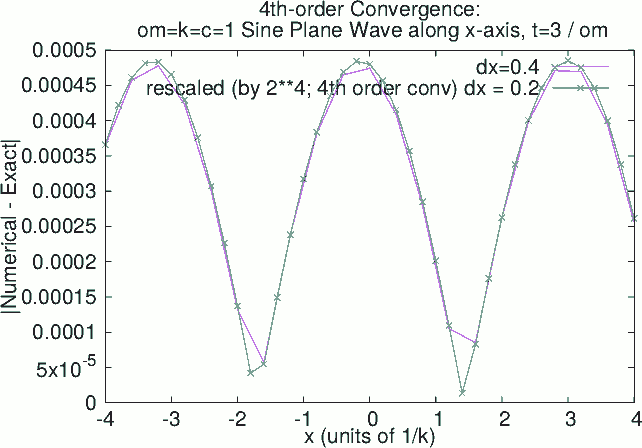

In [8]:
from IPython.display import Image
Image("./WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/out-RK4-FD4-1D.png", width=600, height=600)

Next we perform the same test, but with a plane wave propagating along the x=y=z diagonal. This test verifies that errors in propagation along the y and z directions converge to zero as expected as well.

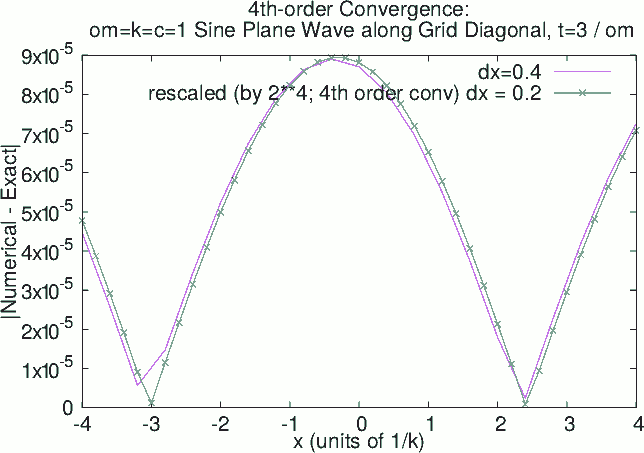

In [9]:
Image("./WaveToyNRPy/example_parfiles/4thOrder_ConvergenceTests/out-RK4-FD4-3D.png", width=600, height=600)

#### Three-dimensional scalar wave equation code tests, adopting *eighth*-order finite differencing, coupled to *RK8* method-of-lines for time integration

Inside the directory *WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTests/* are the files used for this convergence test:
1. **planewave_along_3D_diagonal\*.par** : ETK parameter files needed for performing the 3D tests. These parameter files set up a sinusoidal plane wave propagating along the x=y=z diagonal of a 3D numerical grid that extends from -12 to +12 along the x-, y-, and z-axis (in units of $\omega=k=c=1$). The parameter files are identical, except one has grid resolution that is twice as high (so the errors should drop in the higher resolution case by a factor of $2^4$, since we adopt fourth-order-convergent timestepping and spatial finite differencing.)
1. **runscript.sh** : Runs the cactus executable (assumed to be named *cactus_etilgrmhd-FD8*) for all of the above parameter files.
    1. **convert_IOASCII_1D_to_gnuplot.sh** : Used by **runscript.sh** to convert the 1D output from the execution into a format that [gnuplot](http://gnuplot.info/) can recognize.
1. **gnuplot_script** : Script for creating code validation convergence plots with [gnuplot](http://gnuplot.info/).

**Eighth-order code validation test results:**

The plot below shows the discrepancy between numerical and exact solutions to the scalar wave equation at two different resolutions: purple is low resolution ($\Delta x_{\rm low}=0.4$) and green is high resolution ($\Delta x_{\rm high}=0.2$). Since this test adopts **eighth**-order finite differencing for spatial derivatives and **eighth**-order Runge-Kutta (RK8) for timestepping, we would expect this error to drop by a factor of approximately $(\Delta x_{\rm low}/\Delta x_{\rm high})^8 = (0.4/0.2)^8 = 2^8=256$ when going from low to high resolution, and after rescaling the error in the high-resolution case by 16, we see that indeed it overlaps the low-resolution result quite nicely, confirming fourth-order convergence.

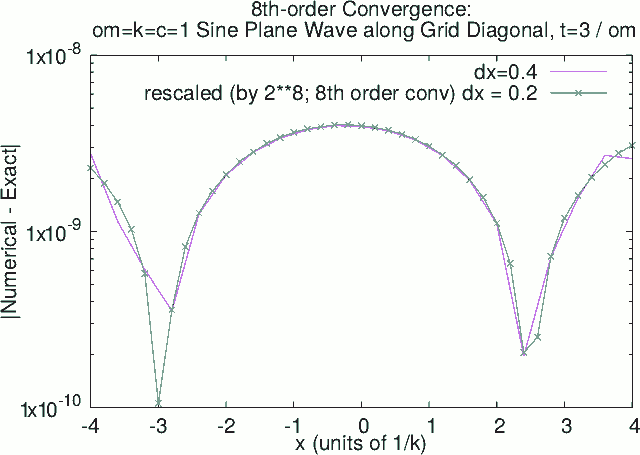

In [10]:
Image("WaveToyNRPy/example_parfiles/8thOrder_ConvergenceTest/FD8-RK8__test_output_plot.png", width=600, height=600)

<a id='latex_pdf_output'></a>

# Step 4: Output this module to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ETK_thorn-WaveToyNRPy.pdf](Tutorial-ETK_thorn-WaveToyNRPy.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [11]:
!jupyter nbconvert --to latex --template latex_nrpy_style.tplx Tutorial-ETK_thorn-WaveToyNRPy.ipynb
!pdflatex -interaction=batchmode Tutorial-ETK_thorn-WaveToyNRPy.tex
!pdflatex -interaction=batchmode Tutorial-ETK_thorn-WaveToyNRPy.tex
!pdflatex -interaction=batchmode Tutorial-ETK_thorn-WaveToyNRPy.tex
!rm -f Tut*.out Tut*.aux Tut*.log

[NbConvertApp] Converting notebook Tutorial-ETK_thorn-WaveToyNRPy.ipynb to latex
[NbConvertApp] Support files will be in Tutorial-ETK_thorn-WaveToyNRPy_files/
[NbConvertApp] Making directory Tutorial-ETK_thorn-WaveToyNRPy_files
[NbConvertApp] Making directory Tutorial-ETK_thorn-WaveToyNRPy_files
[NbConvertApp] Making directory Tutorial-ETK_thorn-WaveToyNRPy_files
[NbConvertApp] Writing 68462 bytes to Tutorial-ETK_thorn-WaveToyNRPy.tex
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
This is pdfTeX, Version 3.14159265-2.6-1.40.18 (TeX Live 2017/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
